In [1]:
from fenics import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
from egfcore import *
from utils import *

set_log_level(30)
%matplotlib widget

In [2]:
class Simulator:
    
    def __init__(self, meshDensity):
        self.mesh = IntervalMesh(meshDensity,0,1) # (meshDensity = N_sensors) =  # of positions at which the problem is discretized on a unit interval
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh.mat", mesh_dict)
        self.V = FunctionSpace(self.mesh, 'P', 2)
        
        V = FunctionSpace(self.mesh,'P',1)
        u = TestFunction(V)
        temp = assemble(u*dx)
        self.meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
        
        
    def boundaryConditions(self):
        """
        Define homogeneous Dirichlet Boundary conditions for the problem
        """
        def boundary(x, on_boundary):
            return on_boundary
        
        u_D = Constant(0)
        bc = DirichletBC(self.V, u_D, boundary)
        
        return bc
        
    def forcing(self, fvals):
        V = FunctionSpace(self.mesh, 'P', 1)
        f = Function(V)
        d2v = dof_to_vertex_map(V)
        f.vector()[:] = fvals[d2v]
        return f
        
    def solve(self, forcing, noise_level = None, param = None):
        """
        Given a (N_sensors x 1) forcing vector, solve the a 1D Poisson problem on a unit interval.
        """
        N = np.shape(self.mesh.coordinates())[0]
        
        f = self.forcing(forcing)      
        bc = self.boundaryConditions()

        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        
        airy = Expression('K*K*x[0]', K = param, degree = 2)
        a = (-dot(grad(u), grad(v)) - airy*u*v)* dx
        L = f*v*dx
        u = Function(self.V)
        solve(a == L, u, bc)

        solution = u.compute_vertex_values(self.mesh)

        if noise_level is not None:
            noise =  noise_level*np.random.normal(0,np.abs(solution.mean()),solution.shape)
            solution += noise

        return solution

In [3]:
%%time
add_noise = False
noise_level = 0.1

# paramSet = np.array([[1.0], [2.0], [3.0], [2.5]])
paramSet = np.array([[1.0], [5.0], [10.0], [7.0]])

meshDensity = 2000
sigma = 0.005
rank = 100
nSamples = rank

Sim = Simulator(meshDensity)
models = []
for i, params in enumerate(paramSet):

    np.random.seed(42)

    print(f"Airy (Theta = $ {params[0]}) | Method: Randomized SVD | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")


    meshweights = Sim.meshweights

    # Generate an forcing and output ensemble by simulating Poisson problem with FENICS.
    forcing = sampleforcing(sigma, nSamples)
    solution = np.zeros(forcing.shape)
    for i in range(solution.shape[1]):
        if add_noise:
            solution[:,i] = Sim.solve(forcing[:,i], noise_level, params[0])
        else:
            solution[:,i] = Sim.solve(forcing[:,i], None, params[0])

    if add_noise:
        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, noise_level, None, None, Sim, verbose = False)
    else:
        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, None, None, None, Sim, verbose = False)
        
    models.append(model)

Airy (Theta = $ 1.0) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
Airy (Theta = $ 5.0) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
Airy (Theta = $ 10.0) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
Airy (Theta = $ 7.0) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
CPU times: user 10.7 s, sys: 1.83 s, total: 12.5 s
Wall time: 2min 27s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
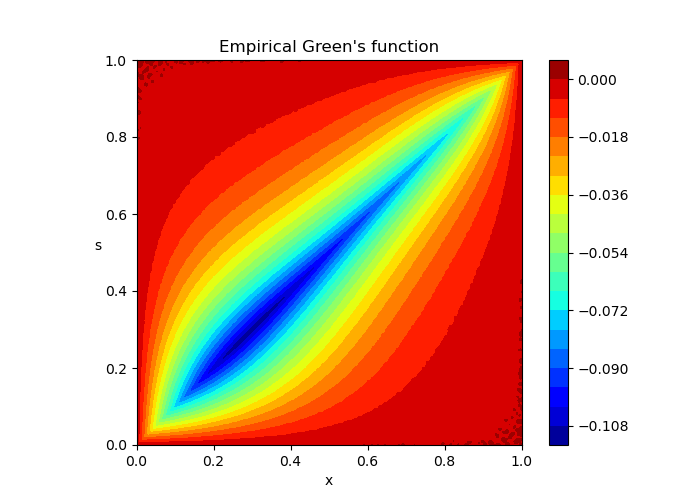

In [4]:
plotGreen1D(models[3])

In [5]:
# U0 = models[0].modeset * np.sqrt(models[0].meshweights)
# U = models[1].modeset * np.sqrt(models[0].meshweights)

# R = np.identity(U.shape[1])
# theta = pi/3
# # R[:2,:2] = np.array([[cos(theta), -sin(theta)],[sin(theta), cos(theta)]])
# R[:2,:2] = np.array([[0,1],[1,0]])
# Ur = U @ R

# # P1 = U - U0 @ (U0.T @ U + U.T @ U0)*0.5
# # P2 = Ur - U0 @ (U0.T @ Ur + Ur.T @ U0)*0.5
# P1 = U0 - U @ np.linalg.inv(U.T @ U) @ U.T @ U0
# P2 = U0 - Ur @ np.linalg.inv(Ur.T @ Ur) @ Ur.T @ U0

# np.linalg.norm(P1-P2)

In [6]:
# plt.figure()
# j = 1
# plt.plot(U[:,j],'b--',alpha = 0.5)
# plt.plot(Ur[:,j],'r', alpha = 0.5)

In [7]:
# plt.figure()
# j = 7
# plt.plot(P1[:,j],'b--',alpha = 0.5)
# plt.plot(P2[:,j],'r', alpha = 0.5)

In [8]:
def model_interp_horizontal(models, Sim, inputdata, targetParam, verbose = False):
    """
    Interpolation for the models (orthonormal basis + coefficients). THe orthonormal basis is interpolated in the
    tangent space of compact Stiefel manifold using a QR based retraction map. The coefficients are interpolated
    directly (entry-by-entry) using a Lagrange polynomial based inteporlation. Note that currently the interpolation
    only supports 1D parameteric spaces for the model as the method for interpolation within the tangent space only
    supports 1D parameteric spaces but this can be easily extended to higher dimensions. The lifting and retraction to
    the tangent space of an "origin" has no dependendence on the dimensionality of the parameteric space. The current
    implementation takes models of type randomized-svd. Again, this is not a limitation of the method as the core
    interpolation scheme is not dependent on the model type but only needs orthonormal bases.

    --------------------------------------------------------------------------------------------------------------------
    Arguments:
        models: Set of models (EGF objects) which are used to generate an interoplated model at the parameter
            targetParam.
        Sim: An object of Simulator class used to generate discretized system responses corresponding to a forcing
                forcing (in case of "randomized-svd" model). The main function for the class is Sim.solve(), which takes
                the params, noise_level, and a forcing vector as input and generates the corresponding system response.
                Note that this process can be implemented more efficiently by reducing the overheads due to multiple
                function calls but for the sake of a better understanding of the method, the solve method takes only one
                forcing vector at a time. Note that the manifold interpolation doesn't require the simulator object. We
                use it to define the EGF objects and then do integrations for visualization. When applying this method
                to real world problems, we don't need it. Defaults to None.
        inputdata: A collection of forcing/input functions sampled at N_sample location. Each discreteized forcing
                function is repsented by a column vector and these columns are stacked together to create this input
                ensemble which is an array of size (N_sensors x N_samples). Note that the manifold interpolation does
                not require the input ensemble. These are used for computing the empirical errors in the model is of
                type "coefficient-fit".
        targetParam: An array of size (n_{param_dimension} x 1) array which defines the parameters for the model which
            we want to interpolate.
        verbose: If set to True, the algorithm generates more debugging info. Defaults to False.

    --------------------------------------------------------------------------------------------------------------------
    Returns:
        An EGF object with the interpolated basis.
    """
    dists = []

    assert(not models == True)
    assert(models[0].type == "randomized-svd")

    nSens = models[0].nSens
    # nIO = models[0].nIO
    rank = models[0].rank
    
    # V = FunctionSpace(Sim.mesh,'P',1)
    # u = TestFunction(V)
    # temp = assemble(u*dx)
    # meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
    

    # Find the model which is closest to target parameter. Note that the distance is calculated in terms of norm of the
    # normalized parameters. 
    for model in models:
        dists.append(np.linalg.norm((model.params-targetParam)/targetParam)) # Element-wise divide is a design choice.
    
    refIndex = np.argmin(dists)
    numModels = len(models)
    
    # Define the basis which is used as the origin.
    # U0, _, _ = np.linalg.svd(np.sqrt(models[refIndex].meshweights) * \
    #                               models[refIndex].G * np.sqrt(models[refIndex].meshweights).T, full_matrices = False)
    U0 = models[refIndex].modeset * np.sqrt(models[refIndex].meshweights)

    # # Interpolation coefficients
    # dists = np.array(dists)
    # rip = np.exp(-dists/np.mean(dists))
    # print(rip)

    a = compute_interp_coeffs(models, targetParam)

    if verbose:
        print(f"Interpolation for dcoeffs: {a}")
    
    coeffs_interp = np.zeros(rank)
    P_interp = np.zeros((nSens, rank))
    
    U_set = [] # Storing these for debugging.
    coeffs_set = [] # Storing these for debugging
    for m in range(numModels):
        # Store the learnt empirical Green's function as a modeset and coefficient matrix.
        # U, S, Vt = np.linalg.svd( np.sqrt(models[m].meshweights) * \
        #                                         models[m].G * np.sqrt(models[m].meshweights).T, full_matrices = False)
        U = models[m].modeset * np.sqrt(model.meshweights)
        dcoeffs = models[m].dcoeffs
        
        # Match the modes and subsequently signs with the basepoint
        order, signs = compute_order_and_signs(U0, U)
        U = U[:,order]*signs
        dcoeffs = dcoeffs[order]


        # Match the basepoints signs
        for i in range(rank):
            if(U[:,i].T @ U0[:,i] < 0):
                U[:,i] = -U[:,i]

        # Project to tangent space of compact Stiefel manifold.
        # P = U - U0 @ (U0.T @ U + U.T @ U0)*0.5 # Project and add along with the weight in the interpolation
        P = U0 - U @ np.linalg.inv(U.T @ U) @ U.T @ U0
        
        # Interpolate the matrices in tangent space and diagonal coefficient set with same interpolation coefficients.
        P_interp += P * a[m]
        coeffs_interp += dcoeffs.squeeze() * a[m]
        U_set.append(U)
        coeffs_set.append(dcoeffs)
    
    # Retract back to compact Stiefel manifold using a QR-decomposition based map.
    modeset, _ = np.linalg.qr(U0 + P_interp)
    # modeset = U0 + P_interp
    
    # Reorder and flip signs. Note that we haven't seen an instance which requires reordering with a QR based map which
    # indeed an issue in case of an SVD based map.
    order, signs = compute_order_and_signs(U0, modeset)

    modeset = modeset[:,order] * signs
    modeset = modeset / np.sqrt(model.meshweights)
    # coeffs_interp = coeffs_interp[order]

    # Create an EGF object to return
    interp_model = EGF(None, targetParam, rank, Sim.mesh, inputdata, \
                            None, None, modeset, coeffs_interp, Sim, verbose = False)
    return interp_model, U_set, coeffs_set

In [9]:
%%time

# Interpolation

print(f"Parameter set: {paramSet}")
interpSet = [models[0], models[1], models[2]]
# interpSet = [models[0], models[2]]


targetParam = paramSet[-1]
targetModel = models[-1]
inputdata = models[-1].forcing #compute_forcing(pSim.mesh, numSteps)
simulator = Sim

interpModel, U_set, _ = model_interp(interpSet, simulator, inputdata, targetParam, verbose = False)
interpModelhorizontal, U_set_horizontal, _ = model_interp_horizontal(interpSet, simulator, inputdata, targetParam, verbose = False)

Parameter set: [[ 1.]
 [ 5.]
 [10.]
 [ 7.]]
CPU times: user 1.78 s, sys: 606 ms, total: 2.39 s
Wall time: 565 ms


In [10]:
# plt.figure()
# plt.plot(targetModel.dcoeffs,'b-', linewidth = 0.7, alpha = 1)
# plt.plot(interpModel.dcoeffs,'r--', linewidth = 0.7, alpha = 1)
# plt.legend(['Target coefficients','Interpolated coefficients'])
# plt.title('Coefficients (S)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
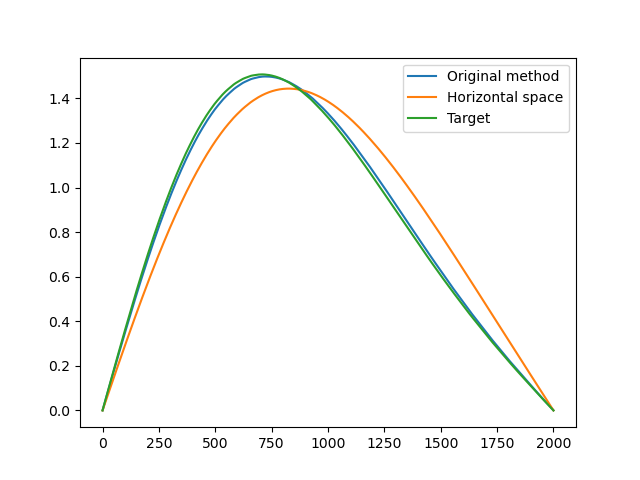

In [11]:
plt.figure()
plt.plot(interpModel.modeset[:,0])
plt.plot(interpModelhorizontal.modeset[:,0])
plt.plot(targetModel.modeset[:,0])
plt.legend(['Original method', 'Horizontal space','Target'])

Text(0.5, 1.0, 'Interpolated Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
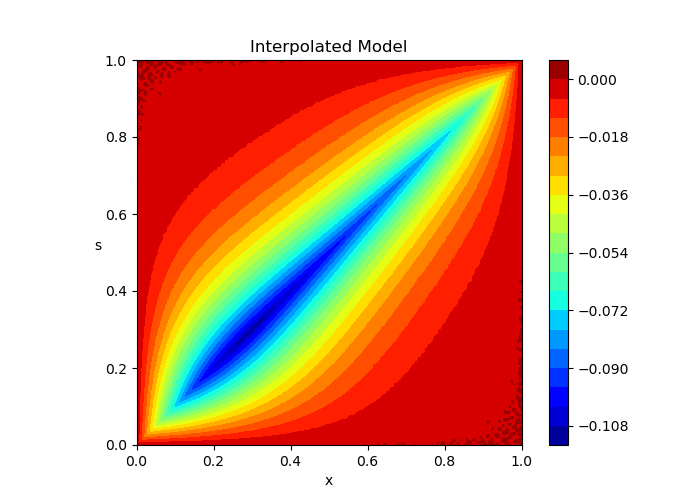

In [12]:
plotGreen1D(interpModel)
plt.title('Interpolated Model')

Text(0.5, 1.0, 'Interpolated Model (horizontal')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
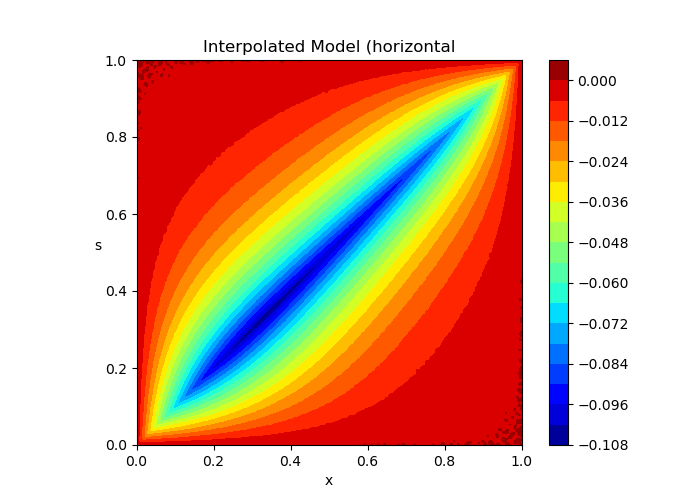

In [13]:
plotGreen1D(interpModelhorizontal)
plt.title('Interpolated Model (horizontal')

Text(0.5, 1.0, 'Target Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
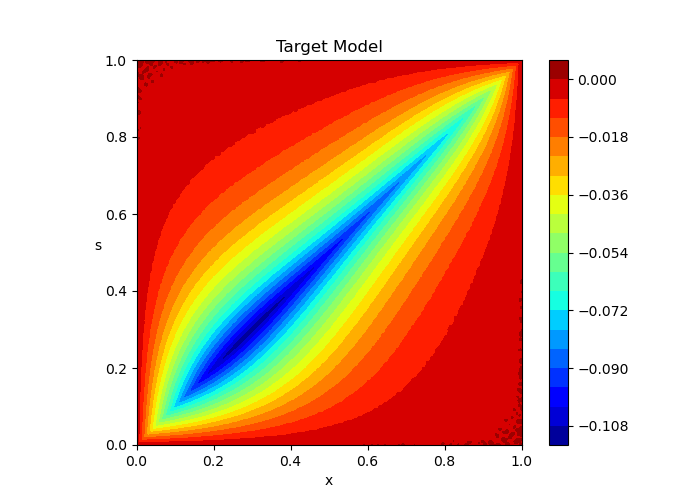

In [14]:
plotGreen1D(targetModel)
plt.title('Target Model')

In [15]:
def computeEmpiricalError(model, Sim, sigma, nSamples, noise_level = None):
    seed = 1
    np.random.seed(1)

    # Generate an forcing and output ensemble for testing
    forcing = sampleforcing(sigma, nSamples, seed)
    solution = np.zeros(forcing.shape)
    for i in range(nSamples):
        if add_noise:
            solution[:,i] = Sim.solve(forcing[:,i], noise_level, model.params[0])
        else:
            solution[:,i] = Sim.solve(forcing[:,i], None, model.params[0])
    
    reconstruction = model.reconstruct_signal(forcing)
    
    error = np.zeros(nSamples)
    for i in range(nSamples):
        V = FunctionSpace(Sim.mesh, 'P', 1)
        d2v = dof_to_vertex_map(V)
        temp = Function(V)
        temp.vector()[:] = np.square(reconstruction[:,i] - solution[:,i])[d2v]
        num = assemble(temp*dx)
        temp.vector()[:] = np.square(solution[:,i])[d2v]
        den = assemble(temp*dx)
        
        error[i] = np.sqrt(num/den)
        
    return error

In [16]:
err = computeEmpiricalError(interpModel, Sim, sigma, nSamples, noise_level = None)
print(f"Max error: {np.max(err)}")
print(f"Mean error: {np.mean(err)}")

Max error: 0.038431178239622756
Mean error: 0.02602855230969605


In [17]:
err = computeEmpiricalError(interpModelhorizontal, Sim, sigma, nSamples, noise_level = None)
print(f"Max error: {np.max(err)}")
print(f"Mean error: {np.mean(err)}")

Max error: 0.1394191389841753
Mean error: 0.08360718570983777


In [18]:
# Manifold interpolation

errorL2(reconstructEGF1D(interpModel), reconstructEGF1D(targetModel), interpModel.meshweights)

0.02652073001252675

In [19]:
# Manifold interpolation

errorL2(reconstructEGF1D(interpModelhorizontal), reconstructEGF1D(targetModel), interpModelhorizontal.meshweights)

0.08449497436568805